# Spatial Analysis of Temperature Variations

This notebook focuses on the spatial analysis of temperature variations across different regions of California. The objective is to map average temperatures at different geographic levels, identify regions with significant temperature variations and visualize possible hotspots.

### Learnings:
- Identify regions in California with significant temperature variations.
- Detect potential temperature hotspots.
- Understand the spatial distribution of temperature.

## Set Up

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium 
import os
import sys

# Update paths to get source code from notebook_utils
curr_dir = os.path.dirname(os.path.abspath('notebooks'))
proj_dir = os.path.dirname(curr_dir)
src_path = os.path.join(proj_dir, 'src')
sys.path.append(src_path)

from notebook_utils.spatial_analysis import *
from notebook_utils.preprocessing import *

# Create combined dataframe from ghcn_cleaned files
dfs = combine_files_to_dfs('../data/processed/ghcn_cleaned')
CA_stations = pd.concat(dfs, ignore_index=True)

Processed file: CA_2003_clean.csv
Processed file: CA_2004_clean.csv
Processed file: CA_2005_clean.csv
Processed file: CA_2006_clean.csv
Processed file: CA_2007_clean.csv
Processed file: CA_2008_clean.csv
Processed file: CA_2009_clean.csv
Processed file: CA_2010_clean.csv
Processed file: CA_2011_clean.csv
Processed file: CA_2012_clean.csv
Processed file: CA_2013_clean.csv
Processed file: CA_2014_clean.csv
Processed file: CA_2015_clean.csv
Processed file: CA_2016_clean.csv
Processed file: CA_2017_clean.csv
Processed file: CA_2018_clean.csv
Processed file: CA_2019_clean.csv
Processed file: CA_2020_clean.csv
Processed file: CA_2021_clean.csv
Processed file: CA_2022_clean.csv
Processed file: CA_2023_clean.csv


# Load Spatial Data

In [2]:
# Load California places, county, and state boundary shapefiles
county_gdf = gpd.read_file('../data/raw/shapefiles/CA_County_Boundaries/CA_Counties.shp')
places_gdf = gpd.read_file('../data/raw/shapefiles/CA_Places_Boundaries/CA_Places.shp')
state_gdf = gpd.read_file('../data/raw/shapefiles/CA_State_Boundaries/CA_State.shp')

### Reproject GeoDataFrames to match temperature data's Coordinate Reference System

In [3]:
county_gdf = county_gdf.to_crs(epsg=4326)
places_gdf = places_gdf.to_crs(epsg=4326)
state_gdf = state_gdf.to_crs(epsg=4326)

### Convert dataframe to geodataframe

In [4]:
geometry = [Point(xy) for xy in zip(CA_stations['Longitude'], CA_stations['Latitude'])]
CA_stations_gdf = gpd.GeoDataFrame(CA_stations,geometry=geometry,crs='EPSG:4326')

# Merge Data

## Combine station data with spatial data

### County Boundaries

In [5]:
# Spatial join between temperature data and county boundaries
county_temp_gdf = gpd.sjoin(CA_stations_gdf, county_gdf, how='inner', predicate='intersects')
county_avg = county_temp_gdf.groupby('NAME')['Temperature'].mean().reset_index()
county_gdf = county_gdf.merge(county_avg,  on='NAME', how='left')
county_gdf.rename(columns={'Temperature_y': 'Temperature'}, inplace=True)

### City/Place Boundaries

In [6]:
# Spatial join between temperature data and places boundaries
places_temp_gdf = gpd.sjoin(CA_stations_gdf, places_gdf, how="inner", predicate='intersects')
place_avg = places_temp_gdf.groupby('NAME')['Temperature'].mean().reset_index()
gdf_places = places_gdf.merge(place_avg, on='NAME')

# Visualization

#### Fill counties with no temperature observations with NaN

In [7]:
county_gdf['Temperature'].fillna(np.nan)

0           NaN
1     15.821148
2     14.127806
3           NaN
4     15.599405
5     16.383903
6     12.783784
7     17.429678
8     16.658171
9     13.654825
10    15.431253
11          NaN
12    11.546602
13          NaN
14    13.712835
15    17.243536
16    13.803385
17          NaN
18    14.612431
19    21.412654
20          NaN
21          NaN
22    16.691870
23    19.643110
24    15.754577
25          NaN
26     7.749531
27          NaN
28    16.493582
29          NaN
30    12.760748
31    18.810790
32    16.743648
33          NaN
34    11.161445
35     9.565418
36    18.206730
37    16.911427
38    15.470045
39    17.301562
40    16.548322
41    14.681901
42     7.844763
43    16.914273
44    16.176895
45    17.149641
46    17.195268
47    17.396288
48          NaN
49          NaN
50          NaN
51          NaN
52          NaN
53    14.705365
54    11.019756
55    13.450512
56          NaN
57    14.951725
Name: Temperature, dtype: float64

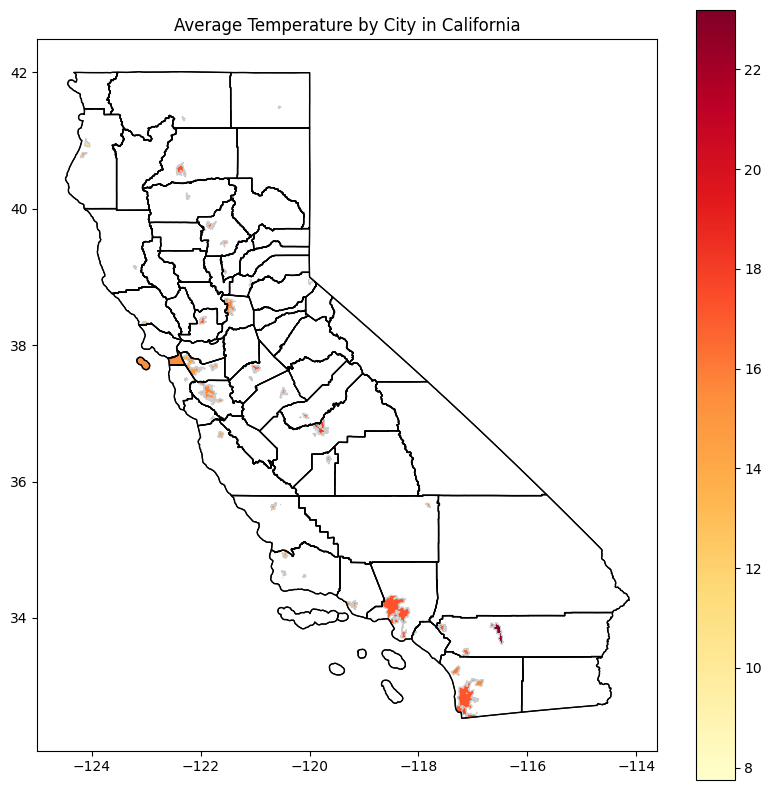

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
county_gdf.boundary.plot(ax=ax, linewidth=1, color='black', label='County Boundaries')
county_gdf.boundary.plot(ax=ax,linewidth=0.8,color='black')
gdf_places.plot(column='Temperature', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Average Temperature by City in California')
plt.show()

# (Optional) Interpolation